Harvard NLP 의 [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)를 구현하는 것을 목표로 해보자.

# Prelims

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='talk')
%matplotlib inline

# Model Architecture

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.srd_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mak):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

<img src='./transformer.png'>

## Encoder and Decoder Stacks

### Encoder

인코더는 $N=6$개의 동일한 레이어를 쌓아서 만든다.

In [4]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

Residual connection과 layer normailzation을 도입한다. 또한 각각의 sublayer에 dropout을 도입한다.

In [6]:
a = torch.rand(2,4)
a

tensor([[0.9153, 0.6661, 0.5379, 0.0969],
        [0.5634, 0.8127, 0.7820, 0.4595]])

In [7]:
a.mean(-1, keepdim=False), a.mean(-1, keepdim=True)

(tensor([0.5541, 0.6544]), tensor([[0.5541],
         [0.6544]]))

In [8]:
a.size(), a.mean(-1, keepdim=False).size(), a.mean(-1, keepdim=True).size()

(torch.Size([2, 4]), torch.Size([2]), torch.Size([2, 1]))

In [9]:
class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x-mean) / (std+self.eps) + self.b_2

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as oppposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
        # 처음 시작 단계에도 normalization이 필요한가?

각각의 레이어는 두 개의 서브레이어를 포함한다. 첫번째는 멀티헤드 셀프어텐션이고 두번째는 단순한 위치별 FC 레이어이다.

In [11]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        "Follow the above figure (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

디코더도 비슷함...

In [12]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

인코더에 비해 디코더는 하나의 서브레이어가 더 필요하며, 여기서는 인코더의 아웃풋을 받아서 멀티헤드 셀프어텐션을 수행한다.

In [14]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow the above figure (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x,m,m,src_mask))
        return self.sublayers[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [15]:
def subsequent_mask(size):
    "Mask out subsequent postions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

#### numpy.triu($m, k=0$)
Upper triangle of an array. Return a copy of a matrix with the elements below the $k$-th diagonal zeroed.

In [23]:
np.triu(np.ones([4,4]), k=1), np.triu(np.ones([4,4]), k=0), np.triu(np.ones([4,4]), k=2)

(array([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]), array([[1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]]), array([[0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

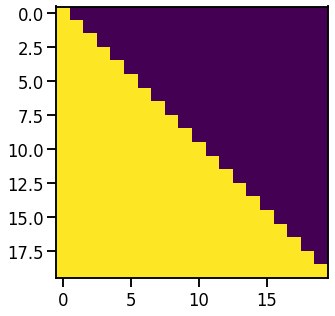

In [26]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None
# 각각의 타겟 단어(행)가 참조할 수 있는 범위(열)을 보여준다.

### Attention